In [74]:
%matplotlib inline
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from rlutils import Agent, enact_policy, evaluate_agent, state_cols
from collections import deque
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
from itertools import permutations
from agent import *
plt.rcParams['figure.dpi'] = 150

In this notebook, we develop a reinforcement learning model to fold proteins on a two-dimensional lattice. 

<h1> Step 1) Build the Environment </h1>

In [50]:
"""Actions/State


        | (0,0) | U/1|  (2,0) |
        |L/4    | X  | R/2    |
        | (0,2) | D/3| (2,2)  |
""" 


class BPFEnv():
    def __init__(self, n_residues_max, residues):
        assert len(residues) <= n_residues_max, "Invalid Protein"
        # self.hyperparameters = ? may need some here
        residues_ = []
        for i in range(len(residues)):
            if(i < len(residues)):
                residues_ += [residues[i]]
            else:
                residues_ += [0]
        self.state = np.array(([0]*(n_residues_max*2 + 1)**2) + residues_ + [n_residues_max, n_residues_max])
        self.n_residues_max = n_residues_max
        # flat representation of the state
    def make_state_pretty(self):
        #convert the flat representation of the state into something more easily useable
        nrm = self.n_residues_max
        grid = self.state[:(2*nrm+1)**2].reshape(2*nrm+1, 2*nrm+1)
        residues = self.state[(2*nrm+1)**2:(2*nrm+1)**2+nrm]
        pos = [self.state[-2], self.state[-1]]
        return [grid, residues, pos]
    def state_from_pretty(self, pretty):
        grid = pretty[0]
        residues = pretty[1]
        pos = pretty[2]
        state_ = np.concatenate([grid.flatten(), residues], axis=0)
        state_ = np.concatenate([state_, pos], axis=0)
        self.state = state_
        
    def increment(self, action):
        # double check the move makes sense
        assert action in [1,2,3,4], "Action " +str(action) + " is invalid"
        
        state_prime = self.make_state_pretty()
        board = state_prime[0]
        residues = state_prime[1]
        position = state_prime[2]
        
        position[0] += (action % 2 ==0) * (np.sign(3-action)) # i.e. if the action is divisible by 2 (right or left) with appropriate sign
        position[1] += (not action%2 == 0) * (np.sign(action-2)) # these lines just move where our cursor is
        board[position[0],position[1]] = residues[0] # change board at cursor to leading residues
        residues = [residues[i] for i in range(1, len(residues))] + [0] # remove first residue
        self.state = np.concatenate([board.flatten(), residues, position], axis=0)
    def reset(self):
        n_residues_max = self.n_residues_max
        residues_ = list(np.random.randint(2,size=n_residues_max)*2 - 1)
        self.state = np.array(([0]*(n_residues_max*2 + 1)**2) + residues_ + [n_residues_max, n_residues_max])
        return self.state
    def compute_energy(self):
        state = self.make_state_pretty()
        # first attempt at the energy functional
        side_of_board_reward = 0
        energy = 0
        board = state[0]
        for k in range(len(board)):
            for l in range(len(board[k])):
                nbers = [board[i][j] for i in range(k-1, k+2) for j in range(l-1, l+2) if i > -1 and j > -1 and j < len(board[0]) and i < len(board)]
                # check the number of like neighbors
                energy += np.sum(np.array(nbers).sum() * board[k][l])
        return energy
                    
    def step(self, action):
        assert action in [0,1,2,3], "Action " +str(action) + " is invalid"
        action = action+1 # I wrote this poorly :)
        done = False
        reward = 0
        old_pretty = self.make_state_pretty()
        old_pretty[0] = old_pretty[0].copy()
        old_pretty[1] = old_pretty[1].copy()
        old_pretty[2] = old_pretty[2].copy()
        
        self.increment(action)
        new_pretty = self.make_state_pretty()
        #now we need to implement the rewards
        
        #SELF - AVOIDING
        if(not np.count_nonzero(new_pretty[0]) > np.count_nonzero(old_pretty[0])):
            # this means the action overlapped with a previous residue
            reward += 0.01
            done = True
        if(np.count_nonzero(old_pretty[1]) <= 1):
            reward += 0.5
            done = True #finished protein
        #ENERGY 
        if(not done):
            en = self.compute_energy()
            if(en > 0):
                #really try to get it to fold lol.
                en = en*3
            reward += en
        return self.state, reward, done, {}

    def show(self):
        # display a picture of the current state
        state_ = self.make_state_pretty()
        x = state_[0]
        green = [[i,j] for i in range(len(x)) for j in range(len(x[i])) if x[i][j] == -1]
        blue =  [[i,j] for i in range(len(x)) for j in range(len(x[i])) if x[i][j] == 1]
        green = np.array(green)
        blue = np.array(blue)
        if(np.count_nonzero(green) > 0):
            plt.scatter(green[:,0],green[:,1],color="green", lw=5)
        if(np.count_nonzero(blue) > 0):
            plt.scatter(blue[:, 0], blue[:, 1],color="teal", lw=5)
        plt.xlim(0,self.n_residues_max*2 +1)
        plt.ylim(0,self.n_residues_max*2 +1)
        plt.grid()
        

<h3> Now we can train the model with the Binary Protein Folding Environment </h3>

In [7]:
env = BPFEnv(5, [1,1,1,-1,-1])
agent = DQNAgent(len(env.state))
dqn_results = agent.evaluate_agent(env, 100)

In [ ]:
def moving_average(array,n=10):
    avg = []
    for i in range(len(array)):
        bottom = np.max([1, i-n])
        top = i
        avg += [np.mean(array[bottom:top])]
    return np.array(avg)
plt.plot(dqn_results["episode"], moving_average(dqn_results["length"]))
plt.xlabel("Episode")
plt.ylabel("Run Length Moving Average")
plt.savefig("run_length.png")

We can see that this instance of the model seems to slowly learn the self-avoiding behaivor. Now we will conduct some more thorough analysis.

<h1> Step 2) Model Analysis </h1>

In the following cells, we build a few helper functions to test the model's performance. The `minimum_energy_grid()` function finds the global optimum solution using an inefficient grid search. This lets us compare the model to "perfect" performance. We compare the model's performance against a random benchmark, in which each folding action is taking randomly.

In [38]:
def fold_protein(env_, agent_, verbose = False):
    # fold a protein i.e. run the policy on the environment
    list_acts = []
    for i in range(env_.n_residues_max):
        act_ = agent.get_action(env_.state)
        list_acts += [act_]
        env_.step(act_)
    if(verbose):
        return (env_, list_acts)
    return env_
def fold_protein_by_action_list(env_, action_list_):
    # just a helper for comparisons
    for i in range(env_.n_residues_max):
        env_.step(action_list_[i])
    return env_

In [57]:
def minimum_energy_grid(residues):
    minimum_energy = None
    total_possibilities = 4**len(residues)
    best_fold = []
    for k in range(total_possibilities):
        # generate grid of actions
        start_env = BPFEnv(len(residues), residues)
        actions_ = []
        
        for i in range(len(residues)):
            actions_ += [int(np.floor(k/(4**i)) % (4))]
        self_avoiding = True
        # fold protein
        for action_ in actions_:
            old_pretty = start_env.make_state_pretty()
            old_pretty[0] = old_pretty[0].copy()
            old_pretty[1] = old_pretty[1].copy()
            old_pretty[2] = old_pretty[2].copy()
            start_env.step(action_)
            new_pretty = start_env.make_state_pretty()
            if(not np.count_nonzero(new_pretty[0]) > np.count_nonzero(old_pretty[0])):
                # this means the action overlapped with a previous residue
                self_avoiding = False
        if(self_avoiding):
            if(minimum_energy is None):
                minimum_energy = start_env.compute_energy()
            new_energy = start_env.compute_energy()
            if(new_energy > minimum_energy):
                minimum_energy = new_energy
                best_fold = actions_
    return (best_fold, minimum_energy)

In [191]:
def model_comparison(agent, n_max_residues, residues_list, n_test = 2):
    exact_energy = {}
    model_energy = {}
    random_energy = {}
    no_fold_energy = {}
    for k in tqdm(range(len(residues_list))):
        residue = residues_list[k]
        #set up the environments we want to compare
        model_env = BPFEnv(n_max_residues, residue)
        random_env = BPFEnv(n_max_residues, residue)
        no_fold_env = BPFEnv(n_max_residues, residue)
        #calculate the energies and save the energies and best fold to
        #a dictionary for comparision later
        exact_ = minimum_energy_grid(residue)
        exact_energy[str(residue)] = [exact_[1], exact_[0]]
        model_, actions = fold_protein(model_env, agent, True)
        lattice, _ , _ = model_.make_state_pretty()
        # check if self avoiding 
        if(np.count_nonzero(lattice) < len(residue)):
            model_energy[str(residue)] = [0, actions]
        else:
            model_energy[str(residue)] = [model_.compute_energy(), actions]
        # generate a random fold to compare to the model
        random_actions = [np.random.randint(0,4) for i in range(len(residue))]
        random_ = fold_protein_by_action_list(random_env, random_actions)
        # check if self avoiding
        lattice, _, _ = random_.make_state_pretty()
        if(np.count_nonzero(lattice) < len(residue)):
            random_energy[str(residue)] = [0, random_actions]
        else:
            random_energy[str(residue)] = [random_.compute_energy(), random_actions]
        no_fold_ = fold_protein_by_action_list(no_fold_env, [0] * len(residue))
        no_fold_energy[str(residue)] = [no_fold_.compute_energy(),  [0] * len(residue)]
    return exact_energy, model_energy, random_energy, no_fold_energy

In [142]:
def dict_mare(dict_, comparison_dict_, only_successful=False): # calculate the Mean Absolute Relative Error
    energies = []
    comparison_energies = []
    for key in dict_:
        if(dict_[key][0] != 0 or not only_successful):
            energies += [dict_[key][0]]
            comparison_energies += [comparison_dict_[key][0]]
    return np.mean(np.abs(np.array(energies) - np.array(comparison_energies)))/(np.mean(comparison_energies))

In [136]:
def count_invalid(dict_):
    s=0
    for key in dict_:
        s += (dict_[key][0] == 0)
    return s

<h1> Step 3) Effect of Training Length </h1>

First, we will test how the number of episodes during training affects the model's performance. In order to do this, we train models with various episode lengths and then evaluate its performance on a test set of random proteins. We compare the model's performance against a benchmark model which applies random folds to the protein. This should provide an estimate about how well the model understands the system.

In [187]:
test_episodes = [100,500,1000,1500,2000]

In [72]:
trained_agents = []
length_results = []
for episode_length in test_episodes:
    print("Initializing model")
    env = BPFEnv(5, [1,1,1,-1,-1])
    print("Training model for ", episode_length, " episodes")
    agent = DQNAgent(len(env.state))
    dqn_results = agent.evaluate_agent(env, episode_length)
    trained_agents += [agent]

Initializing model
Training model for  100  episodes


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [01:39<00:00,  9.90s/it]


Initializing model
Training model for  500  episodes


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [01:41<00:00, 10.12s/it]


Initializing model
Training model for  1000  episodes


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [01:48<00:00, 10.87s/it]


Initializing model
Training model for  1500  episodes


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [01:41<00:00, 10.11s/it]


Initializing model
Training model for  2000  episodes


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [01:47<00:00, 10.76s/it]


In [195]:
length_results = []
residues_list = [[np.random.randint(2)*2 - 1 for i in range(5)] for j in range(10)]
for agent in trained_agents:
    results = model_comparison(agent, 5, residues_list, n_test=10)
    length_results += [results]

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [01:47<00:00, 10.72s/it]


In [196]:
model_errors = [dict_mare(i[1], i[0], False) for i in length_results]
random_errors = [dict_mare(i[2], i[0], False) for i in length_results]
no_fold_errors = [dict_mare(i[3], i[0], False) for i in length_results]

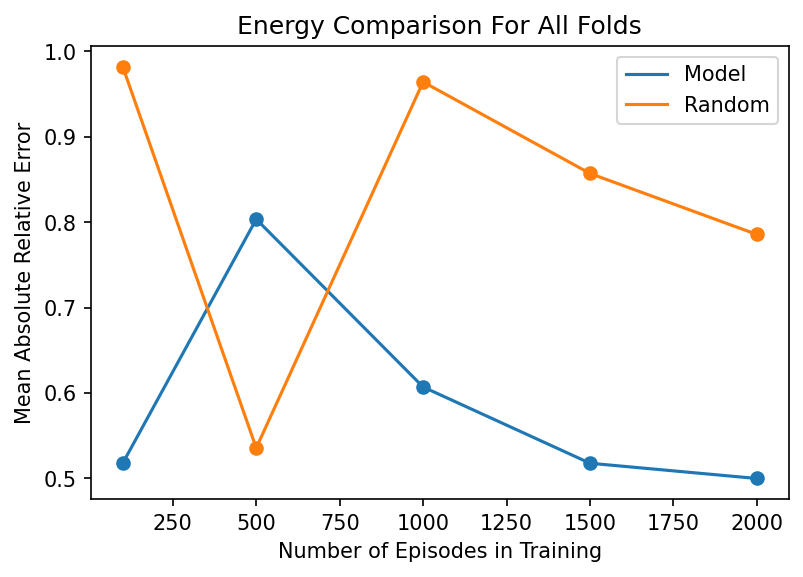

In [201]:
plt.plot(test_episodes, model_errors, label="Model")
plt.scatter(test_episodes, model_errors)
plt.plot(test_episodes, random_errors, label="Random")
plt.scatter(test_episodes, random_errors)
plt.xlabel("Number of Episodes in Training")
plt.ylabel("Mean Absolute Relative Error")
plt.title("Energy Comparison For All Folds")
plt.legend()
plt.savefig("episode_length.png")

In [198]:
model_errors_2 = [dict_mare(i[1], i[0], True) for i in length_results]
random_errors_2 = [dict_mare(i[2], i[0], True) for i in length_results]
no_fold_errors_2 = [dict_mare(i[3], i[0], True) for i in length_results]

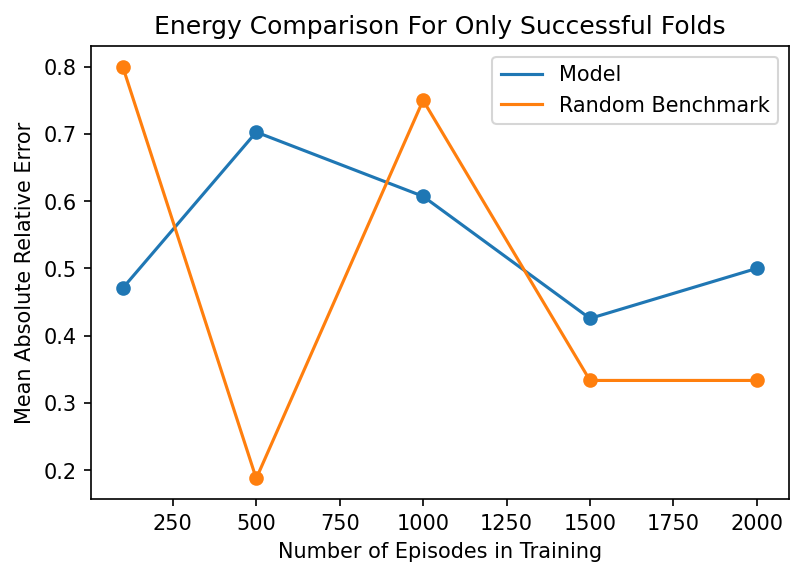

In [202]:
plt.plot(test_episodes, model_errors_2, label="Model")
plt.scatter(test_episodes, model_errors_2)
plt.plot(test_episodes, random_errors_2, label="Random Benchmark")
plt.scatter(test_episodes, random_errors_2)
plt.xlabel("Number of Episodes in Training")
plt.ylabel("Mean Absolute Relative Error")
plt.title("Energy Comparison For Only Successful Folds")
plt.legend()
plt.savefig("episode_length_only_successful.png")

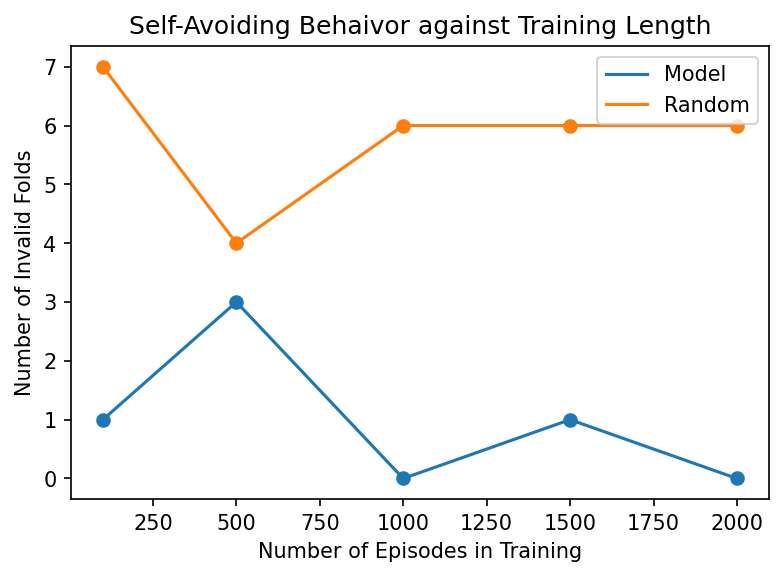

In [203]:
plt.plot(test_episodes, [count_invalid(i[1]) for i in length_results], label="Model")
plt.scatter(test_episodes, [count_invalid(i[1]) for i in length_results])
plt.plot(test_episodes, [count_invalid(i[2]) for i in length_results], label="Random")
plt.scatter(test_episodes, [count_invalid(i[2]) for i in length_results])
plt.xlabel("Number of Episodes in Training")
plt.ylabel("Number of Invalid Folds")
plt.title("Self-Avoiding Behaivor against Training Length")
plt.legend()
plt.savefig("invalid_folds.png")

<h1> Step 4) Generalization to Higher Dimensions </h1>

In [189]:
trained_agents_higher_dimensions = []
dimensions_results = []
dimensions = [3, 5, 7]
for dimension in dimensions:
    print("Initializing model")
    env = BPFEnv(dimension, [1]*dimension)
    print("Training model with dimension ", dimension)
    agent = DQNAgent(len(env.state))
    dqn_results = agent.evaluate_agent(env, 1000)
    trained_agents_higher_dimensions += [agent]

Initializing model
Training model with dimension  3


Initializing model
Training model with dimension  5


Initializing model
Training model with dimension  7


In [204]:
dimension_results = []
for i in range(len(dimensions)):
    agent = trained_agents_higher_dimensions[i]
    residues_list = [[np.random.randint(2)*2 - 1 for i in range(dimensions[i])] for j in range(10)]
    print(dimensions[i])
    results = model_comparison(agent, dimensions[i], residues_list, n_test=10)
    dimension_results += [results]

3


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.67it/s]


5


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [01:40<00:00, 10.01s/it]


7


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [1:07:03<00:00, 402.36s/it]


In [205]:
model_errors_dim = [dict_mare(i[1], i[0], False) for i in dimension_results]
random_errors_dim = [dict_mare(i[2], i[0], False) for i in dimension_results]
no_fold_errors_dim = [dict_mare(i[3], i[0], False) for i in dimension_results]

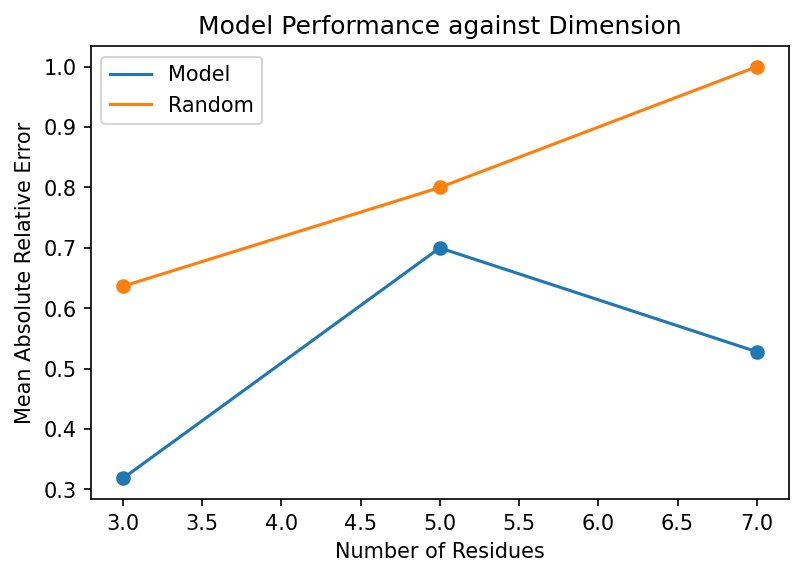

In [209]:
plt.plot(dimensions, model_errors_dim, label="Model")
plt.scatter(dimensions, model_errors_dim)
plt.plot(dimensions, random_errors_dim, label="Random")
plt.scatter(dimensions, random_errors_dim)
plt.xlabel("Number of Residues")
plt.ylabel("Mean Absolute Relative Error")
plt.title("Model Performance against Dimension")
plt.legend()
plt.savefig("dimension.png")

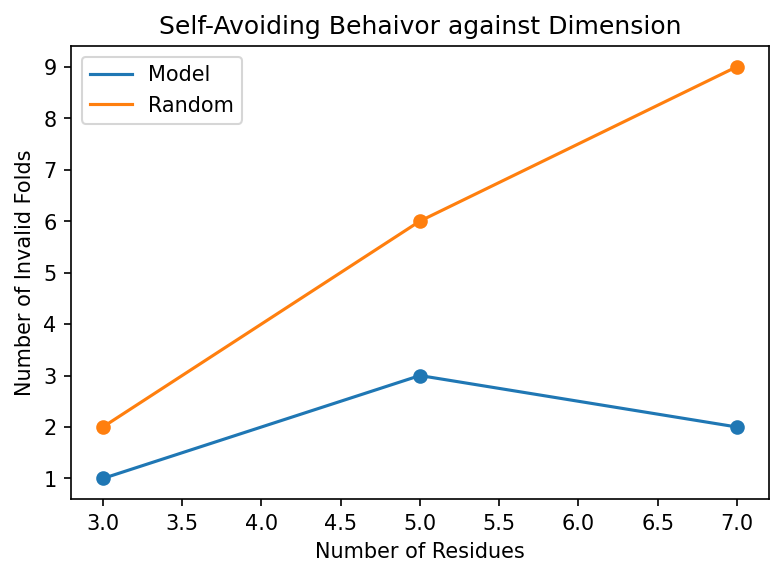

In [210]:
plt.plot(dimensions, [count_invalid(i[1]) for i in dimension_results], label="Model")
plt.scatter(dimensions, [count_invalid(i[1]) for i in dimension_results])
plt.plot(dimensions, [count_invalid(i[2]) for i in dimension_results], label="Random")
plt.scatter(dimensions, [count_invalid(i[2]) for i in dimension_results])
plt.xlabel("Number of Residues")
plt.ylabel("Number of Invalid Folds")
plt.title("Self-Avoiding Behaivor against Dimension")
plt.legend()
plt.savefig("invalid_folds_dim.png")